In [16]:
# the following line just makes the cells appear wider:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import units as u
from astropy import constants as c
# import pandas as pd
# import string


In [28]:
class calculate_spin(object):
    """
    This class calculates the Black Hole (BH) or Neutron Star (NS) spin based on a given spin prescription
    It returns the spin of the compact object M1, and compact object M2
    The available spin prescriptions are:
    []
    
    """

    
    def __init__(self, data_path=None, spin_model_name='uniform'):
    
        self.path                = data_path
        
        if (self.path is None):
            print("Warning: your hdf5 path is set to 'None'")
        elif not  os.path.isfile(data_path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%data_path)
        elif os.path.isfile(data_path):
            self.h5file           = h5.File(data_path)
            
            
        self.spin_model_name = spin_model_name
        
        
    def random_uniform_spin(self, low, high):   
        import random
        
        sample_size = len(self.h5file['doubleCompactObjects']['M1'][...].squeeze())
        
        self.spinM1 = np.random.uniform(low=low, high=high, size=sample_size)
        self.spinM2 = np.random.uniform(low=low, high=high, size=sample_size)
        
        
        return self.spinM1, self.spinM2
    
    
    def fixed_value_spin(self, spin_value):   
        
        M1samples = self.h5file['doubleCompactObjects']['M1'][...].squeeze()
        
        self.spinM1 = np.ones_like(a=M1samples) * spin_value
        self.spinM2 = np.ones_like(a=M1samples) * spin_value
        
        
        return self.spinM1, self.spinM2
    
        
    def setCOMPASData(self):
        """ reads in some of the COMPAS parameters needed from hdf5 file """
        
        fDCO      = self.h5file['doubleCompactObjects'] # hdf5 file with the DCO information
        fSN       = self.h5file['supernovae']  # hdf5 file with the SN information
        #
        self.M1 = fDCO['M1'][...].squeeze()   # Compact object mass [Msun] of the initially more massive star
        self.M2 = fDCO['M2'][...].squeeze()  # Compact object mass [Msun] of the initially less massive star
        self.metallicitySystems  = fDCO['Metallicity1'][...].squeeze() 
        
        self.seedsDCO = fDCO['seed'][...].squeeze()  # get the seeds in the DCO file 
        self.seedsSN = fSN['randomSeed'][...].squeeze()    # get the seeds in the SN file 
        maskSNdco = np.in1d(self.seedsSN,  self.seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
        whichSN = fSN['whichStar'][...].squeeze()[maskSNdco]   # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova
        whichSN2 = whichSN[1::2] # get whichStar for the first SN   (there are 2 SNe for all DCOs)       
        
        self.separationPreSN2= fSN['separationBefore'][...].squeeze()[maskSNdco][1::2] # the separation just before each SN  in [Rsun], we need only the separation for the second SN to occur, so the [1::2]  

        self.convert_a_to_P_circular(separation=self.separationPreSN2*u.Rsun, M1=self.M1*u.Msun, M2=self.M2*u.Msun)  # obtain the Period before the SNe
        self.PeriodPreSN2 = self.PeriodPreSN2.to(u.d).value
        self.MassCOM2CoreSN = fSN['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        self.MassCOM1CoreSN = fSN['MassCOCoreSN'][...].squeeze()[maskSNdco][0::2]
        
        self.st1 = fDCO['stellarType1'][...].squeeze()   # obtain the final stellar type of the Primary 
        self.st2 = fDCO['stellarType2'][...].squeeze()   # obtain the final stellar type of the Secondary
        
        self.spinM1, self.spinM2 = np.zeros_like(self.M1), np.zeros_like(self.M2)  # start by giving all primaries zero spin and all secondaries zero spin 
        # did M1 form in the first SN?
        self.M1formedSecond =  (whichSN2==1) # mask that is 1 if the  compact object M1 formed first in the DCO
        # did M2 form in the first SN?
        self.M2formedSecond =  (whichSN2==2)  # mask that is 1 if the compact object M2 formed first in the DCO
        mask_SN1not1or2 = (whichSN2!=1) & (whichSN2!=2)
        
        
#         self.mWR =  fdata['supernovae']['MassCOCoreSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe
        self.mWR =  fSN['MassStarSN'][...].squeeze()[maskSNdco][1::2]   # obtain the CO core mass before the SNe


    def function_f_Bavera21(self, c1, c2, c3):
        """
        m_WR with units using astropy


        """

        top = -c1
        bottom = c2 + np.exp(-c3*self.mWR)

        f = top/bottom


        return f  
    
   
    def convert_a_to_P_circular(self, separation, M1, M2):
        """calculate Period from separation
        separation is separation (needs to be given in astropy units)
        M1 and M2 are masses of the binary

        """
        G = c.G # [gr cm s^2]


        mu = G*(M1+M2)
        self.PeriodPreSN2 = 2*np.pi * np.sqrt(separation**3/mu)

          
    def calculate_alpha_beta_Bavera21(self):
        
        # numerical coefficients form text below Eq 2
        # we use the values at helium depletion, since we later on use the C/O core mass. 
        c1_alpha, c2_alpha, c3_alpha =  0.059305, 0.035552, 0.270245
        c1_beta,  c2_beta, c3_beta   =  0.026960, 0.011001, 0.420739

        alpha = self.function_f_Bavera21(c1_alpha, c2_alpha, c3_alpha)
        beta  = self.function_f_Bavera21(c1_beta,  c2_beta,  c3_beta)

        return alpha, beta



        
        
    def Bavera_spin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 

        based on Eq 1 and 2 from https://arxiv.org/pdf/2105.09077.pdf
    
    
        """
        
        # the following function reads in the COMPAS DCO parameters such as WR mass and sets self.spinM1, self.spinM2 
        # to arrays of zeros
        self.setCOMPASData() 
        
        ## Calculate spin for the ones that tidally spin up ##
        
        alpha, beta = self.calculate_alpha_beta_Bavera21()  #obtain alpha and beta 
        
        # define mask of BHs that can have spin through tidal spin up
        # if BH (self.st==14) & formed second (self.M1formedFirst==0) & has pre-SN period (WR-BH period) of < 1 day, calculate spin with the approximation
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedSecond==1)) & (np.log10(self.PeriodPreSN2) < 1)
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedSecond==1)) & (np.log10(self.PeriodPreSN2) < 1)
        
        # Bavera approximation: 
        first_term = (alpha* (np.log10(self.PeriodPreSN2)**2)) 
        second_term =  ( beta * np.log10(self.PeriodPreSN2))  
        self.spinM1[maskGiveSpin1]  =  first_term[maskGiveSpin1]  + second_term[maskGiveSpin1]  
        self.spinM2[maskGiveSpin2]  =  first_term[maskGiveSpin2]  + second_term[maskGiveSpin2] 
        
        #for some binaries the properties fall outside of the fit, we set these artificial to spin 0 
        n_negative_spin1 = np.sum(self.spinM1<0)
        self.spinM1[self.spinM1<0] = np.zeros(n_negative_spin1)
        n_negative_spin2 = np.sum(self.spinM2<0)
        self.spinM2[self.spinM2<0] = np.zeros(n_negative_spin2)
        
        
        return self.spinM1, self.spinM2
    
    
    
    
    def QinSpin(self):
        """
        Returns spinM1 and spinM2, the spins of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this approximation only a BH that is formed second can be tidally spun up, if its 
        pre-SN separation is tight enough. 
        
        see Qin+18, approximation originally given in https://ui.adsabs.harvard.edu/abs/2021MNRAS.504.3682C 
        (and Equation 5 in https://arxiv.org/pdf/2103.02608.pdf)
        
        """
        
        # the following function reads in the COMPAS DCO parameters such as WR mass and sets self.spinM1, self.spinM2 
        # to arrays of zeros
        self.setCOMPASData() 
        
        m_, c_ = -5./3, 0.5 # from Qin + 2018 

        # if BH & formed second and tight enought at WR-BH phase, calculate spin with Qin+18 approximation for systems that have spin 1 
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedSecond==1) &  (np.log10(self.PeriodPreSN2) < -0.3))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedSecond==1) &  (np.log10(self.PeriodPreSN2) < -0.3))
        # the systems above have maximum spin
        self.spinM1[maskGiveSpin1] = np.ones(np.sum(maskGiveSpin1)) # fill with ones 
        self.spinM2[maskGiveSpin2] = np.ones(np.sum(maskGiveSpin2)) # fill with ones 
  
        
        # now assign the spin for systems that lie in between the 0 and 1 spin using the fitting formulae
        maskGiveSpin1 = ((self.st1==14) & (self.M1formedSecond==1) &  (np.log10(self.PeriodPreSN2) >= -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3))
        maskGiveSpin2 = ((self.st2==14) & (self.M2formedSecond==1) &  (np.log10(self.PeriodPreSN2) >= -0.3) &  (np.log10(self.PeriodPreSN2) < 0.3))

        self.spinM1[maskGiveSpin1] =  m_ * np.log10(self.PeriodPreSN2[maskGiveSpin1])  + c_   
        self.spinM2[maskGiveSpin2] =  m_ * np.log10(self.PeriodPreSN2[maskGiveSpin2])  + c_   
              
    
        return self.spinM1, self.spinM2

    
    
    def Z_dependent_spin_param(self, metallicity_range, prescription_name):
        """ 
        returns metallicity dependent spin parameter coefficients of fitting formula for the Geneva or MESA prescription 
        by Belczynski et al. (2020); https://www.aanda.org/10.1051/0004-6361/201936528. Prescription_name should be in ['Geneva', 'MESA']
        """
        # from Table 1 in http://arxiv.org/abs/2301.01312 


        if metallicity_range >= 0.010:
            return [2.258, 16.0, 24.2, 0.13] if prescription_name=='Geneva' else  [-0.0016, 0.115, np.inf, np.inf, np.inf]

        elif (metallicity_range >= 0.004) & (metallicity_range < 0.010):
            return [3.578, 31.0, 37.8, 0.25] if prescription_name=='Geneva' else  [-0.0006, 0.105, np.inf, np.inf, np.inf]

        elif (metallicity_range >= 0.0012) & (metallicity_range < 0.004):
            return [2.434, 18.0, 27.7, 0.0 ] if prescription_name=='Geneva' else  [-0.0076, 0.050, -0.0019, 0.165, 12.09]


        elif (metallicity_range < 0.0012):
            return [3.666, 32.0, 38.8, 0.25] if prescription_name=='Geneva' else  [-0.0010, 0.125, np.inf, np.inf, np.inf]


    def GenevaSpin(self):
        '''
        returns spins of the primary (spinM1) and secondary (spinM2) 
        based on the Geneva BH natal spin model as described in Belczsynski+20 
        See Equation 3 and Fig 1 in https://www.aanda.org/10.1051/0004-6361/201936528 
        this model assumes moderate BH birth spins, with a spin magnitude dependent on metallicity and CO core mass
        Warning: this function currently assumes the two stars have identical metallicity (add a Z mask to change this)
        ''' 

        # apply spin model on metallicity ranges that linearly span Z values by Belczysnki (cf. http://arxiv.org/abs/2301.01312) 
        Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]]  # Tab. 1 conditions in http://arxiv.org/abs/2301.01312 

        self.setCOMPASData()  # read in required COMPAS data (CO mass, and metallicity)
        
        # loop over four metallicity ranges of prescription
        for _, Z_range in enumerate(Z_ranges):
            
            mask_inside_Z = (self.metallicitySystems >= Z_range[0]) & (self.metallicitySystems < Z_range[1])  # mask systems inside metallicity range
            b_, m1_, m2_, a_low = self.Z_dependent_spin_param(metallicity_range=Z_range[0], prescription_name='Geneva')  # obtains metallcity dependent model coefficients 
            
            ### apply Equation 3 in Belczynski et al. (2020) ###
            # set spins to max spin value of 0.85 for stars below lower CO core mass (m_1) condition:
            self.spinM1[(self.MassCOM1CoreSN <= m1_)&(mask_inside_Z==1)], spinM2[(self.MassCOM2CoreSN <= m1_)&(mask_inside_Z==1)] = 0.85, 0.85
            
            # set spins to linear interpolation for CO masses in between m_1 and m_2 (a=-0.088 in eq. 3):
            mask_spin1 = (self.MassCOM1CoreSN > m1_) &  (self.MassCOM1CoreSN < m2_) & (mask_inside_Z==1)
            mask_spin2 = (self.MassCOM2CoreSN > m1_) &  (self.MassCOM2CoreSN < m2_) & (mask_inside_Z==1)
            self.spinM1[mask_spin1], self.spinM2[mask_spin2] = (-0.088*self.MassCOM1CoreSN[mask_spin1]) + b_, (-0.088*self.MassCOM2CoreSN[mask_spin2]) + b_
            
            # set spins to min spin value 'a_low' for stars above lower CO core mass (m_2) condition:
            self.spinM1[(self.MassCOM1CoreSN >= m2_)&(mask_inside_Z==1)], self.spinM2[(self.MassCOM2CoreSN >= m2_)&(mask_inside_Z==1)] = a_low, a_low


        return self.spinM1, self.spinM2
    

    
    def MESASpin(self):
        '''
        returns spins of the primary (spinM1) and secondary (spinM2) 
        based on the Geneva BH natal spin model as described in Belczsynski+20 
        See Equation 3 and Fig 1 in https://www.aanda.org/10.1051/0004-6361/201936528 
        this model assumes moderate BH birth spins, with a spin magnitude dependent on metallicity and CO core mass
        Warning: this function currently assumes the two stars have identical metallicity (add a Z mask to change this)
        ''' 
        # MESA spin prescription see from Table 1 in http://arxiv.org/abs/2301.01312 

        self.setCOMPASData()
        
        Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 


        for _, Z_range in enumerate(Z_ranges):
            mask_inside_Z = (self.metallicitySystems >= Z_range[0]) & (self.metallicitySystems < Z_range[1]) # mask inside metallicity range
            b_, m1_, m2_, a_low = self.Z_dependent_spin_param(metallicity_range=Z_range[0], prescription_name='MESA')


            self.spinM1[(self.mWR <= m1_)&(mask_inside_Z==1)], self.spinM2[self.mWR <= m1_] = 0.85, 0.85
            mask_spin = (self.mWR > m1_) & (self.mWR < m2_)
            self.spinM1[mask_spin], self.spinM2[mask_spin] = -0.088*self.mWR[mask_spin] + b_, -0.088*self.mWR[mask_spin] + b_
            self.spinM1[self.mWR >= m2_], self.spinM2[self.mWR >= m2_] = a_low, a_low


        return self.spinM1, self.spinM2
    
        
    
    


## Plotting code 

In [25]:

# some plotting code, it should be fairly straightforward what the code does


def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 25, second=False, labelpad=None, setMinor=True, ):
    """
    Some code to do the layout for axes in matplotlib in a nice way 
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')


    if labelSizeMajor==10:
        ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    else:
        ax.set_xlabel(nameX, fontsize=labelSizeMajor,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=labelSizeMajor,labelpad=labelpad)#, fontweight='bold')  

    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax



def plot_scatter_spin(spin_values, spin_model_name):
    """
    Creates scatter plot to compare pre-second-SN properties (WR mass, Period), and final BH spin
    Can be used to compare to plots shown in Bavera et al. (2021); https://arxiv.org/abs/2105.09077
    """
    
    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(spin.mWR[0:100000], spin.PeriodPreSN2[0:100000],  c=spin_values[0:100000])

    ylabel=r'Period [day]'
    xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '

    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1, 70)
    plt.ylim(0.05, 10)

    cbar = plt.colorbar()
    cbar.set_label('spin', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    # plt.savefig('./BBH_COMPAS_model_A.png', dpi=600)#,\
    plt.show()


    
    
def plot_scatter_Belczynski_spin(spin_values, spin_model_name):
    """
    Creates plot that shows the spin values versus the CO core mass to compare to Fig 1. in Belczynski et al. (2020)
    https://www.aanda.org/10.1051/0004-6361/201936528 
    """

    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(spin.MassCOM1CoreSN[0:], spin_values[0:],  c=np.log10(spin.metallicitySystems[0:]))



    ylabel=r'spin m1 '
    xlabel=r'$m_{\rm{CO}} \, [M_{\odot}]$ '

#     plt.xscale('log')
#     plt.yscale('log')
    plt.xlim(0, 70)
    plt.ylim(0.0, 1)

    cbar = plt.colorbar()
    cbar.set_label(r'$Z$', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    # plt.savefig('./BBH_COMPAS_model_A.png', dpi=600)# uncomment if you want to save the figure 
    plt.show()
    


def plot_histogram_spin(spin_values, spin_model_name, weights):
    """
    Creates weighted histogram of black hole spins (spin_values)
    """



    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.hist(spin_values[0:], weights=weights[0:], bins=100)

    ylabel=r'PDF (rate) $\rm{Gpc}^{-3} \rm{yr}^{-1}$' 
    xlabel=r'spin '

    plt.xlim(0, 1)

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    # plt.savefig('./BBH_COMPAS_model_A.png', dpi=600)#,\
    plt.show()



    
    
    
def plot_scatter_general(xx, yy, cc, spin_model_name, ylabel=r'Period [day]', xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '):




    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(xx[0:100000], yy[0:100000],  c=cc[0:100000])




#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(1, 70)
#     plt.ylim(0.05, 10)

    cbar = plt.colorbar()
    cbar.set_label('spin', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    # plt.savefig('./BBH_COMPAS_model_A.png', dpi=600)#,\
    plt.show()
    
    
    

# Examples 

## Example 1: random uniform spin for each Black Hole (BH)

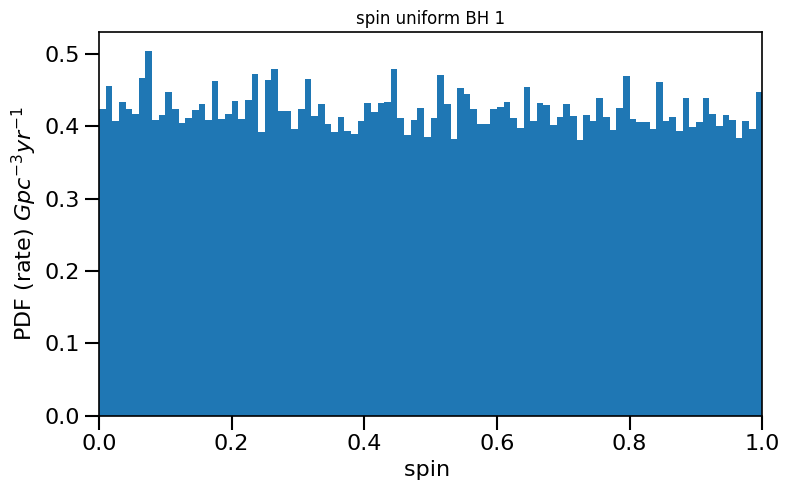

In [5]:
DCOtype='BBH'
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 


spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.random_uniform_spin(low=0.0,high=1)


fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()
plot_histogram_spin(spin_values=(spinM1), spin_model_name=' uniform BH 1', weights=w_intrinsic)




## Example 2: all BH spin have a fixed value

[0.5 0.5 0.5 ... 0.5 0.5 0.5]


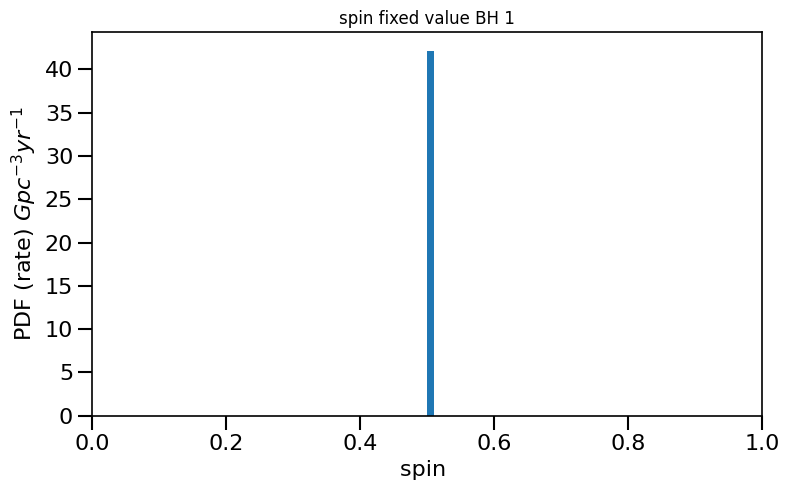

In [6]:
spinM1, spinM2  = spin.fixed_value_spin(spin_value=0.5)
print(spinM1)

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()
plot_histogram_spin(spin_values=(spinM1), spin_model_name=' fixed value BH 1', weights=w_intrinsic)


## Example 3: second formed black hole obtains spin through tides at Wolf-Rayet (WR)-BH stage 
Often described as "Bavera+21 prescription" or "Efficient core-envelope coupling presciption", or "Fuller" model

In [26]:
DCOtype='BBH'
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 

spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.Bavera_spin()



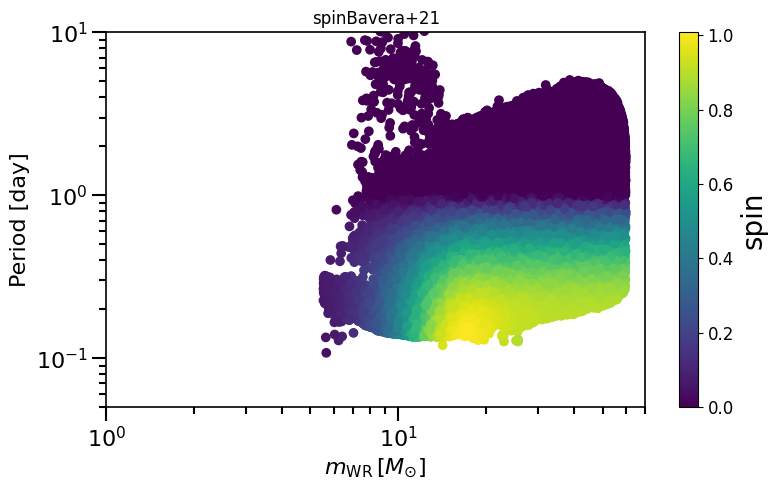

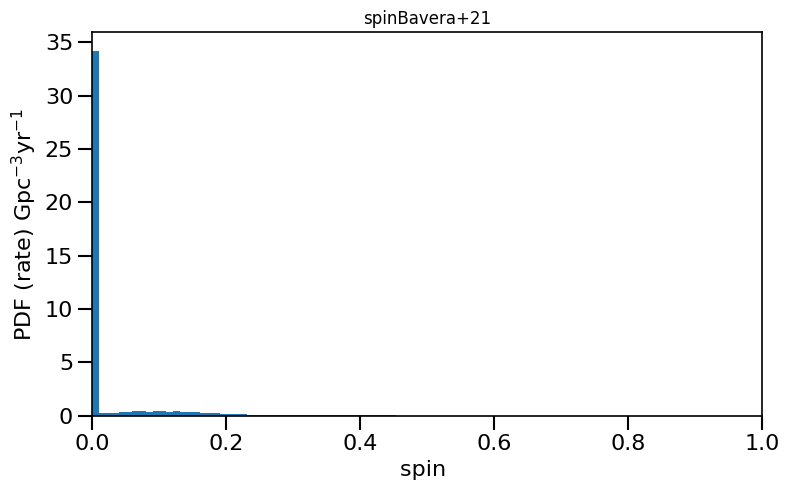

In [27]:

# note that we are plotting both the spinM2 and spinM1, spinM1 can only be nonzero if it went supernova second (due to rejuvenation). This almost never occurs. 
# plot figure showing pre-SN properties 
plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21')

# plot histogram
fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()
plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21', weights=w_intrinsic)



## spin Geneva (birth)

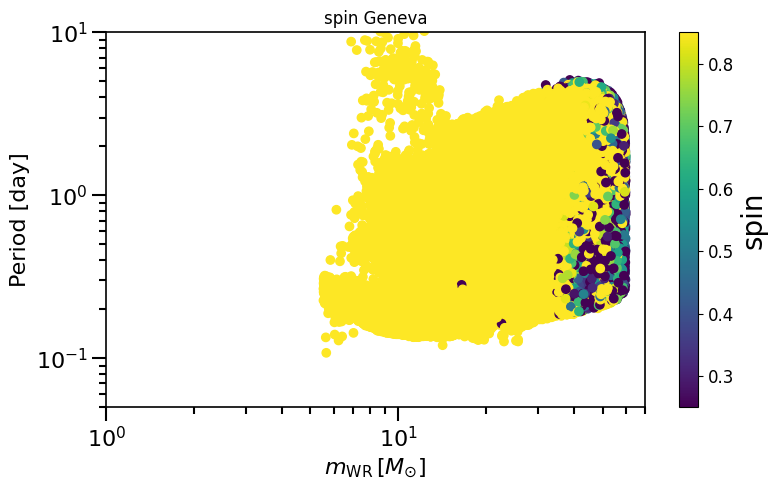

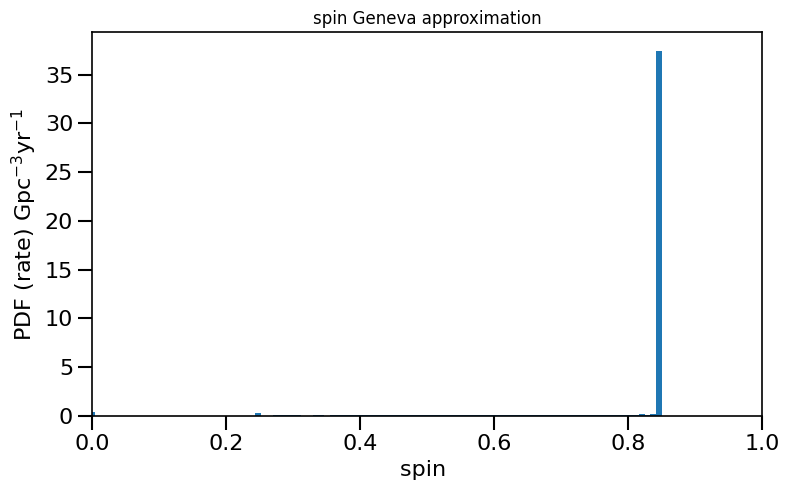

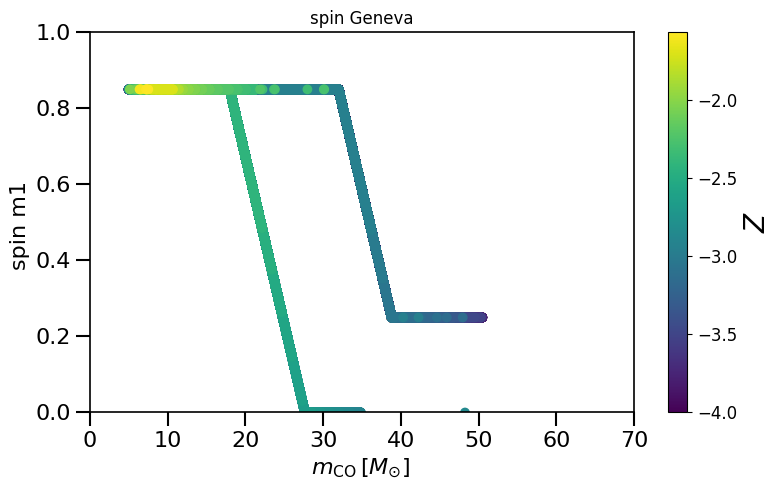

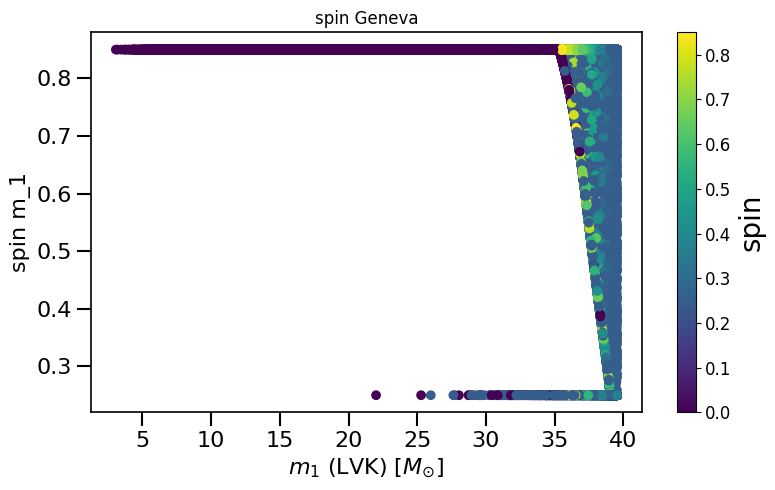

In [30]:
spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.GenevaSpin()


plot_scatter_spin(spin_values=(spinM1), spin_model_name=' Geneva')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1), spin_model_name=' Geneva approximation', weights=w_intrinsic)


plot_scatter_Belczynski_spin(spin_values=(spinM1), spin_model_name=' Geneva')



LVKM1 = np.maximum(spin.M1, spin.M2)
plot_scatter_general(xx=LVKM1, yy=spinM1, cc=spinM2, spin_model_name=' Geneva', xlabel=r'$m_1$ (LVK) $[M_{\odot}]$', ylabel='spin m_1')



## spin MESA (birth)

In [ ]:
# spin = calculate_spin(data_path=path)
# spinM1, spinM2  = spin.MESASpin()


# plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model_name='MESA')

# fdata = h5.File(path)
# w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

# plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model_name='MESA', weights=w_intrinsic)


# BHNS

## Bavera 

In [ ]:
DCOtype='BHNS'
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 

spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.Bavera_spin()


plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21', weights=w_intrinsic)


In [ ]:
# Extra material 

## Test of Belczynski prescription 

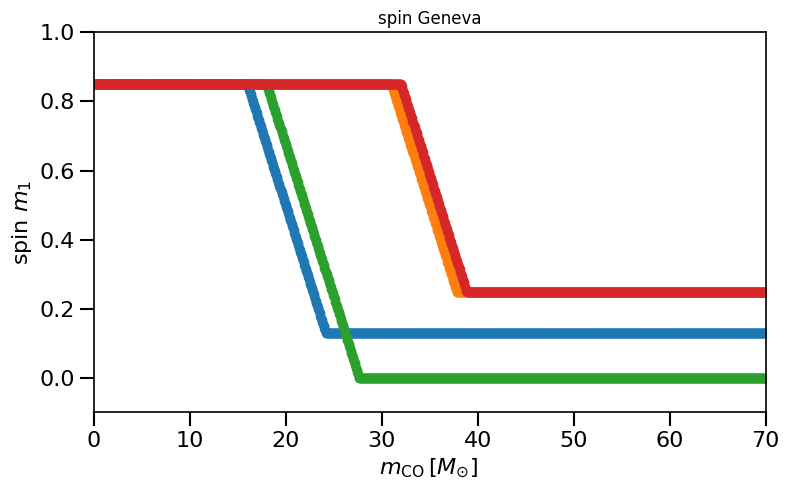

In [35]:
def Z_dependent_spin_param(metallicity_range, prescription_name):
    """ 
    prescription_name in [Geneva, MESA]
    """
    # from Table 1 in http://arxiv.org/abs/2301.01312 


    if metallicity_range >= 0.010:
        return [2.258, 16.0, 24.2, 0.13] if prescription_name=='Geneva' else  [-0.0016, 0.115, np.inf, np.inf, np.inf]

    elif (metallicity_range >= 0.004) & (metallicity_range < 0.010):
        return [3.578, 31.0, 37.8, 0.25] if prescription_name=='Geneva' else  [-0.0006, 0.105, np.inf, np.inf, np.inf]

    elif (metallicity_range >= 0.0012) & (metallicity_range < 0.004):
        return [2.434, 18.0, 27.7, 0.0 ] if prescription_name=='Geneva' else  [-0.0076, 0.050, -0.0019, 0.165, 12.09]


    elif (metallicity_range < 0.0012):
        return [3.666, 32.0, 38.8, 0.25] if prescription_name=='Geneva' else  [-0.0010, 0.125, np.inf, np.inf, np.inf]


def GenevaSpin(metallicitySystems, MassCOM1CoreSN, MassCOM2CoreSN):
    # see from Table 1 in http://arxiv.org/abs/2301.01312 

    spinM1, spinM2 = np.zeros_like(MassCOM1CoreSN), np.zeros_like(MassCOM1CoreSN)
    Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 


    for _, Z_range in enumerate(Z_ranges):

        mask_inside_Z = (metallicitySystems >= Z_range[0]) & (metallicitySystems < Z_range[1]) # mask inside metallicity range
        
        b_, m1_, m2_, a_low = Z_dependent_spin_param(metallicity_range=Z_range[0], prescription_name='Geneva')

        spinM1[(MassCOM1CoreSN <= m1_)&(mask_inside_Z==1)], spinM2[(MassCOM2CoreSN <= m1_)&(mask_inside_Z==1)] = 0.85, 0.85

        mask_spin1 = (MassCOM1CoreSN > m1_) &  (MassCOM1CoreSN < m2_) & (mask_inside_Z==1)
        mask_spin2 = (MassCOM2CoreSN > m1_) &  (MassCOM2CoreSN < m2_) & (mask_inside_Z==1)
        spinM1[mask_spin1], spinM2[mask_spin2] = (-0.088*MassCOM1CoreSN[mask_spin1]) + b_, (-0.088*MassCOM2CoreSN[mask_spin2]) + b_

        spinM1[(MassCOM1CoreSN >= m2_)&(mask_inside_Z==1)], spinM2[(MassCOM2CoreSN >= m2_)&(mask_inside_Z==1)] = a_low, a_low
    return spinM1, spinM2



def plot_scatter_Belczynski_spin(ax, spin_values, MassCOM1CoreSN, spin_model_name):

    plt.scatter(MassCOM1CoreSN[0:], spin_values[0:])



    ylabel=r'spin $m_1$'
    xlabel=r'$m_{\rm{CO}} \, [M_{\odot}]$ '

    plt.xlim(0, 70)
    plt.ylim(-0.1, 1)

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 

    return ax



# this should reproduce Fig 1 in Belczynski et al. (2020; https://www.aanda.org/10.1051/0004-6361/201936528) if implemented correctly:
f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

for Z_ in [0.014, 0.006, 0.002, 0.0004]:
    MassCOM1CoreSN = np.linspace(0.1, 70, 1000)
    MassCOM2CoreSN = np.linspace(0.1, 70, 1000)
    metallicitySystems = Z_*np.ones_like(MassCOM1CoreSN)
    spinM1, spinM2 = GenevaSpin(metallicitySystems, MassCOM1CoreSN, MassCOM2CoreSN)
    plot_scatter_Belczynski_spin(ax, spinM1, MassCOM1CoreSN, ' Geneva')

plt.show()







# Examples with COMPAS data: